In [27]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import numpy as np
from matplotlib import animation
from Quadrotor import Quadrotor_linear

from MPC_controller import mpc_control,mpc_control_stable,OTS,get_observer_gain,luenberger_observer
from visualization import data_for_cylinder_along_z
from convexification import get_intermediate_goal, convexify

np.random.seed(seed=0)
drone = [0,0,0.05]  #pos_x,pos_y,radius
obs1=np.array([-3,1,1])   #pos_x,pos_y,radius
obs2=np.array([-2,-3,1])  #pos_x,pos_y,radius
obs3=np.array([0,2,1]) #pos_x,pos_y,radius
obs4=np.array([-5,-1.9,1]) #pos_x,pos_y,radius
obs5=np.array([0.5,-2,1]) #pos_x,pos_y,radius
#obs6=np.array([-4,-4,1])/1.
obstacle_list=[obs1,obs2,obs3,obs4,obs5]#,obs6]#,obs1*2,obs2*2,obs3*2,obs4*2,obs5*2]

goal = np.array([-6,-6,2]) #pos_x,pos_y,pos_z

sensor_noise_sigma=np.array([0.01,0.01,0.01,0.001,0.001,0.001,0.001,0.001,0.001,0.001])

sensor_noise_sigma = np.zeros(10)
real_disturbance=np.random.normal(loc=0,scale=0.03,size=3)
real_disturbance = np.zeros(3)
print("real _dist", real_disturbance)

Cd= np.zeros((10,3))

Bd= np.array([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 0],
              [1, 0, 0],
              [0, 1, 0],
              [0, 0, 1],
              [0, 0, 0],
              [0, 0, 0],
              [0, 0, 0],
              [0, 0, 0]])


obs_eigen_values= np.array([-0.1, -0.1, -0.1, -0.03, -0.03, -0.03, 0.3, 0.3, 0.6, 0.6, -0.05, -0.05, -0.05])
#obs_eigen_values= np.array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -0.7, -0.7,-0.7])
def animate(i):
    line.set_xdata(real_trajectory['x'][:i + 1])
    line.set_ydata(real_trajectory['y'][:i + 1])
    line.set_3d_properties(real_trajectory['z'][:i + 1])
    
    line_est.set_xdata(real_trajectory['x'][:i + 1])
    line_est.set_ydata(real_trajectory['y'][:i + 1])
    line_est.set_3d_properties(real_trajectory['z'][:i + 1])
    point.set_xdata(real_trajectory['x'][i])
    point.set_ydata(real_trajectory['y'][i])
    point.set_3d_properties(real_trajectory['z'][i])

if __name__ == "__main__":
    traj = []
    for N in np.array([5]):

        quadrotor_linear = Quadrotor_linear()

        x_init = np.zeros(10)
        x_init[0]=drone[0]
        x_init[1]=drone[1]
        
        x_target = np.zeros(10)
        x_target[0] = goal[0]
        x_target[1] = goal[1]
        x_target[2] = goal[2]
        
        x_hat = x_init
        x_real = x_init
        d_hat=np.zeros((3,1))
        output = x_init
        
        L=get_observer_gain(quadrotor_linear, Bd,Cd,obs_eigen_values)
        A,b = convexify(x_init[:2].flatten(),drone[2],obstacle_list)
        
        inter_goal=get_intermediate_goal(x_init[:2].flatten(), 0, x_target[:2].flatten(), A,b).flatten()
        x_intergoal=np.zeros(10)
        x_intergoal[:2]=inter_goal
        x_intergoal[2] = x_target[2]

        real_trajectory = {'x': [], 'y': [], 'z': []}
        est_trajectory = {'x': [], 'y': [], 'z': []}
        output_trajectory = {'x': [], 'y': [], 'z': []}
        
        d_hat_list=[]
        x_ref,u_ref = OTS(quadrotor_linear,x_intergoal,d_hat, A, b, Bd, Cd)

        i = 0
        while np.linalg.norm(x_intergoal[:3].flatten()-x_target[:3]) > 0.1:
            
            i += 1

            A_obs,b_obs=convexify(x_hat[:2].flatten(),drone[2],obstacle_list)

            output = quadrotor_linear.disturbed_output(x_real,real_disturbance, Cd, sensor_noise_sigma)
            
            u = mpc_control(quadrotor_linear, N, x_hat.flatten(), x_ref.flatten(),u_ref.flatten(),A_obs,b_obs)

            if u is None:
                print("no solution")
                u=np.zeros((4,1))
            else:
                u = u.reshape(-1,1)

            est_trajectory['x'].append(x_hat[0])
            est_trajectory['y'].append(x_hat[1])
            est_trajectory['z'].append(x_hat[2])
            
            real_trajectory['x'].append(x_real[0])
            real_trajectory['y'].append(x_real[1])
            real_trajectory['z'].append(x_real[2])
            
            output_trajectory['x'].append(output[0])
            output_trajectory['y'].append(output[1])
            output_trajectory['z'].append(output[2])
            
            x_real = quadrotor_linear.disturbed_next_x(x_real,u,real_disturbance,Bd)
            
            x_hat, d_hat = luenberger_observer(quadrotor_linear, x_hat, d_hat, output, u, Bd, Cd, L)
            
            d_hat_list.append(d_hat)
            
            A_obs,b_obs = convexify(x_hat[:2].flatten(),drone[2],obstacle_list)

            x_intergoal[:2] = get_intermediate_goal(output[:2].flatten(), 0,x_target[:2].flatten(), A_obs,b_obs).flatten()
            
            x_ref,u_ref = OTS(quadrotor_linear, x_intergoal, d_hat, A_obs, b_obs, Bd, Cd)

            if x_ref is None :
                x_ref = x_intergoal
                u_ref = np.zeros((4,1))
            #print("x_error:",(x_real).flatten())
            print(i)
            print("x_real :",x_real.flatten())
            #print("\n")
            #print("ref:",x_ref,u_ref)
            
        A,b = convexify(x_hat[:2].flatten(),drone[2],obstacle_list)
        print("***")

        while np.linalg.norm(x_real[:3].flatten() - x_target[:3]) >= 0.2 and i<=2000:
            i+=1
            
            u = mpc_control_stable(quadrotor_linear, 30, output.flatten(), x_ref.flatten(),u_ref.flatten(),A,b)


            if u is None:
                print("no solution")
                u=np.zeros((4,1))
            else:
                u = u.reshape(-1,1)

            est_trajectory['x'].append(x_hat[0])
            est_trajectory['y'].append(x_hat[1])
            est_trajectory['z'].append(x_hat[2])
            
            real_trajectory['x'].append(x_real[0])
            real_trajectory['y'].append(x_real[1])
            real_trajectory['z'].append(x_real[2])
            
            output_trajectory['x'].append(output[0])
            output_trajectory['y'].append(output[1])
            output_trajectory['z'].append(output[2])
            
            x_real = quadrotor_linear.disturbed_next_x(x_real,u,real_disturbance,Bd)
            
            output = quadrotor_linear.disturbed_output(x_real,real_disturbance, Cd, sensor_noise_sigma).flatten()
            
            x_hat,d_hat = luenberger_observer(quadrotor_linear, x_hat,d_hat,output,u,Bd,Cd,L)
            d_hat_list.append(d_hat)
            x_ref,u_ref = OTS(quadrotor_linear,x_intergoal,d_hat, A,b,Bd,Cd)
            
            if x_ref is None :
                x_ref = x_intergoal
                u_ref = np.zeros((4,1))
        
        traj.append(real_trajectory)
    
    # """ Visualisation """
    # fig = plt.figure(1)
    # ax1 = p3.Axes3D(fig) # 3D place for drawing
    # real_trajectory['x'] = np.array(real_trajectory['x'], dtype=float)
    # real_trajectory['y'] = np.array(real_trajectory['y'], dtype=float)
    # real_trajectory['z'] = np.array(real_trajectory['z'], dtype=float)
    
    # est_trajectory['x'] = np.array(est_trajectory['x'], dtype=float)
    # est_trajectory['y'] = np.array(est_trajectory['y'], dtype=float)
    # est_trajectory['z'] = np.array(est_trajectory['z'], dtype=float)
    
    # output_trajectory['x'] = np.array(output_trajectory['x'], dtype=float)
    # output_trajectory['y'] = np.array(output_trajectory['y'], dtype=float)
    # output_trajectory['z'] = np.array(output_trajectory['z'], dtype=float)
    # point, = ax1.plot([real_trajectory['x'][0]], [real_trajectory['y'][0]], [real_trajectory['z'][0]], 'ro', ms=2.5, label='Quadrotor')
    # line, = ax1.plot([real_trajectory['x'][0]], [real_trajectory['y'][0]], [real_trajectory['z'][0]], label='Real_Trajectory')
    # line_est, = ax1.plot([est_trajectory['x'][0]], [est_trajectory['y'][0]], [est_trajectory['z'][0]], label='est_Trajectory')

    


real _dist [0. 0. 0.]
1
x_real : [ 0.          0.          0.          0.          0.          0.74454379
  0.          0.          0.22042262 -0.44363856]
2
x_real : [ 0.          0.          0.07445438  0.          0.          0.71682651
  0.02204226 -0.04436386  0.18348875 -0.35294049]
3
x_real : [ 0.          0.          0.14613703 -0.04352094 -0.02162346  0.69014108
  0.04039114 -0.07965791  0.11804669 -0.26088474]
4
x_real : [-0.00435209 -0.00216235  0.21515114 -0.12166535 -0.06124716  0.66444907
  0.05219581 -0.10574638  0.08148127 -0.16230613]
5
x_real : [-0.01651863 -0.00828706  0.28159604 -0.22540255 -0.11245125  0.63971349
  0.06034393 -0.12197699  0.04400061 -0.07612373]
6
x_real : [-0.03905888 -0.01953219  0.34556739 -0.34506198 -0.17164865  0.61589876
  0.06474399 -0.12958937 -0.01550103  0.00585621]
7
x_real : [-0.07356508 -0.03669705  0.40715727 -0.47218915 -0.2351625   0.59297058
  0.06319389 -0.12900374 -0.04764927  0.07522085]
8
x_real : [-0.120784   -0.0602133   0.4

In [28]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import numpy as np
from matplotlib import animation
from Quadrotor import Quadrotor_linear

from MPC_controller import mpc_control,mpc_control_stable,OTS,get_observer_gain,luenberger_observer
from visualization import data_for_cylinder_along_z
from convexification import get_intermediate_goal, convexify

np.random.seed(seed=0)
drone = [0,0,0.05]  #pos_x,pos_y,radius
obs1=np.array([-3,1,1])   #pos_x,pos_y,radius
obs2=np.array([-2,-3,1])  #pos_x,pos_y,radius
obs3=np.array([0,2,1]) #pos_x,pos_y,radius
obs4=np.array([-5,-1.9,1]) #pos_x,pos_y,radius
obs5=np.array([0.5,-2,1]) #pos_x,pos_y,radius
#obs6=np.array([-4,-4,1])/1.
obstacle_list=[obs1,obs2,obs3,obs4,obs5]#,obs6]#,obs1*2,obs2*2,obs3*2,obs4*2,obs5*2]

goal = np.array([-6,-6,2]) #pos_x,pos_y,pos_z

sensor_noise_sigma=np.array([0.01,0.01,0.01,0.001,0.001,0.001,0.001,0.001,0.001,0.001])

sensor_noise_sigma = np.zeros(10)
real_disturbance=np.random.normal(loc=0,scale=0.03,size=3)
real_disturbance = np.zeros(3)
print("real _dist", real_disturbance)

Cd= np.zeros((10,3))

Bd= np.array([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 0],
              [1, 0, 0],
              [0, 1, 0],
              [0, 0, 1],
              [0, 0, 0],
              [0, 0, 0],
              [0, 0, 0],
              [0, 0, 0]])


obs_eigen_values= np.array([-0.1, -0.1, -0.1, -0.03, -0.03, -0.03, 0.3, 0.3, 0.6, 0.6, -0.05, -0.05, -0.05])
#obs_eigen_values= np.array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -0.7, -0.7,-0.7])
def animate(i):
    line.set_xdata(real_trajectory['x'][:i + 1])
    line.set_ydata(real_trajectory['y'][:i + 1])
    line.set_3d_properties(real_trajectory['z'][:i + 1])
    
    line_est.set_xdata(real_trajectory['x'][:i + 1])
    line_est.set_ydata(real_trajectory['y'][:i + 1])
    line_est.set_3d_properties(real_trajectory['z'][:i + 1])
    point.set_xdata(real_trajectory['x'][i])
    point.set_ydata(real_trajectory['y'][i])
    point.set_3d_properties(real_trajectory['z'][i])

if __name__ == "__main__":
    traj = []
    for N in np.array([10]):

        quadrotor_linear = Quadrotor_linear()

        x_init = np.zeros(10)
        x_init[0]=drone[0]
        x_init[1]=drone[1]
        
        x_target = np.zeros(10)
        x_target[0] = goal[0]
        x_target[1] = goal[1]
        x_target[2] = goal[2]
        
        x_hat = x_init
        x_real = x_init
        d_hat=np.zeros((3,1))
        output = x_init
        
        L=get_observer_gain(quadrotor_linear, Bd,Cd,obs_eigen_values)
        A,b = convexify(x_init[:2].flatten(),drone[2],obstacle_list)
        
        inter_goal=get_intermediate_goal(x_init[:2].flatten(), 0, x_target[:2].flatten(), A,b).flatten()
        x_intergoal=np.zeros(10)
        x_intergoal[:2]=inter_goal
        x_intergoal[2] = x_target[2]

        real_trajectory = {'x': [], 'y': [], 'z': []}
        est_trajectory = {'x': [], 'y': [], 'z': []}
        output_trajectory = {'x': [], 'y': [], 'z': []}
        
        d_hat_list=[]
        x_ref,u_ref = OTS(quadrotor_linear,x_intergoal,d_hat, A, b, Bd, Cd)

        i = 0
        while np.linalg.norm(x_intergoal[:3].flatten()-x_target[:3]) > 0.1:
            
            i += 1

            A_obs,b_obs=convexify(x_hat[:2].flatten(),drone[2],obstacle_list)

            output = quadrotor_linear.disturbed_output(x_real,real_disturbance, Cd, sensor_noise_sigma)
            
            u = mpc_control(quadrotor_linear, N, x_hat.flatten(), x_ref.flatten(),u_ref.flatten(),A_obs,b_obs)

            if u is None:
                print("no solution")
                u=np.zeros((4,1))
            else:
                u = u.reshape(-1,1)

            est_trajectory['x'].append(x_hat[0])
            est_trajectory['y'].append(x_hat[1])
            est_trajectory['z'].append(x_hat[2])
            
            real_trajectory['x'].append(x_real[0])
            real_trajectory['y'].append(x_real[1])
            real_trajectory['z'].append(x_real[2])
            
            output_trajectory['x'].append(output[0])
            output_trajectory['y'].append(output[1])
            output_trajectory['z'].append(output[2])
            
            x_real = quadrotor_linear.disturbed_next_x(x_real,u,real_disturbance,Bd)
            
            x_hat, d_hat = luenberger_observer(quadrotor_linear, x_hat, d_hat, output, u, Bd, Cd, L)
            
            d_hat_list.append(d_hat)
            
            A_obs,b_obs = convexify(x_hat[:2].flatten(),drone[2],obstacle_list)

            x_intergoal[:2] = get_intermediate_goal(output[:2].flatten(), 0,x_target[:2].flatten(), A_obs,b_obs).flatten()
            
            x_ref,u_ref = OTS(quadrotor_linear, x_intergoal, d_hat, A_obs, b_obs, Bd, Cd)

            if x_ref is None :
                x_ref = x_intergoal
                u_ref = np.zeros((4,1))
            #print("x_error:",(x_real).flatten())
            print(i)
            print("x_real :",x_real.flatten())
            #print("\n")
            #print("ref:",x_ref,u_ref)
            
        A,b = convexify(x_hat[:2].flatten(),drone[2],obstacle_list)
        print("***")

        while np.linalg.norm(x_real[:3].flatten() - x_target[:3]) >= 0.2 and i<=2000:
            i+=1
            
            u = mpc_control_stable(quadrotor_linear, 30, output.flatten(), x_ref.flatten(),u_ref.flatten(),A,b)


            if u is None:
                print("no solution")
                u=np.zeros((4,1))
            else:
                u = u.reshape(-1,1)

            est_trajectory['x'].append(x_hat[0])
            est_trajectory['y'].append(x_hat[1])
            est_trajectory['z'].append(x_hat[2])
            
            real_trajectory['x'].append(x_real[0])
            real_trajectory['y'].append(x_real[1])
            real_trajectory['z'].append(x_real[2])
            
            output_trajectory['x'].append(output[0])
            output_trajectory['y'].append(output[1])
            output_trajectory['z'].append(output[2])
            
            x_real = quadrotor_linear.disturbed_next_x(x_real,u,real_disturbance,Bd)
            
            output = quadrotor_linear.disturbed_output(x_real,real_disturbance, Cd, sensor_noise_sigma).flatten()
            
            x_hat,d_hat = luenberger_observer(quadrotor_linear, x_hat,d_hat,output,u,Bd,Cd,L)
            d_hat_list.append(d_hat)
            x_ref,u_ref = OTS(quadrotor_linear,x_intergoal,d_hat, A,b,Bd,Cd)
            
            if x_ref is None :
                x_ref = x_intergoal
                u_ref = np.zeros((4,1))
        
        traj.append(real_trajectory)
    
    # """ Visualisation """
    # fig = plt.figure(1)
    # ax1 = p3.Axes3D(fig) # 3D place for drawing
    # real_trajectory['x'] = np.array(real_trajectory['x'], dtype=float)
    # real_trajectory['y'] = np.array(real_trajectory['y'], dtype=float)
    # real_trajectory['z'] = np.array(real_trajectory['z'], dtype=float)
    
    # est_trajectory['x'] = np.array(est_trajectory['x'], dtype=float)
    # est_trajectory['y'] = np.array(est_trajectory['y'], dtype=float)
    # est_trajectory['z'] = np.array(est_trajectory['z'], dtype=float)
    
    # output_trajectory['x'] = np.array(output_trajectory['x'], dtype=float)
    # output_trajectory['y'] = np.array(output_trajectory['y'], dtype=float)
    # output_trajectory['z'] = np.array(output_trajectory['z'], dtype=float)
    # point, = ax1.plot([real_trajectory['x'][0]], [real_trajectory['y'][0]], [real_trajectory['z'][0]], 'ro', ms=2.5, label='Quadrotor')
    # line, = ax1.plot([real_trajectory['x'][0]], [real_trajectory['y'][0]], [real_trajectory['z'][0]], label='Real_Trajectory')
    # line_est, = ax1.plot([est_trajectory['x'][0]], [est_trajectory['y'][0]], [est_trajectory['z'][0]], label='est_Trajectory')

    


real _dist [0. 0. 0.]
1
x_real : [ 0.          0.          0.          0.          0.          0.88744952
  0.          0.          1.4686899  -2.95925865]
2
x_real : [ 0.          0.          0.08874495  0.          0.          1.31977498
  0.14686899 -0.29592587  0.72700744 -1.35222244]
3
x_real : [ 0.          0.          0.22072245 -0.29030327 -0.14407848  1.22864084
  0.21956973 -0.43114811  0.02416099 -0.24006086]
4
x_real : [-0.02903033 -0.01440785  0.34358653 -0.71325957 -0.35947639  1.14379976
  0.22198583 -0.45515419 -0.23996294  0.52198628]
5
x_real : [-0.10035628 -0.05035549  0.45796651 -1.15976583 -0.57724449  1.06481719
  0.19798954 -0.40295557 -0.39913925  0.8855837 ]
6
x_real : [-0.21633287 -0.10807994  0.56444823 -1.55506524 -0.77147223  0.99128859
  0.15807561 -0.3143972  -0.63025661  1.02939829]
7
x_real : [-0.37183939 -0.18522716  0.66357709 -1.86348889 -0.92654441  0.92283734
  0.09504995 -0.21145737 -0.58011722  0.97966422]
8
x_real : [-0.55818828 -0.2778816   0.7

In [29]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import numpy as np
from matplotlib import animation
from Quadrotor import Quadrotor_linear

from MPC_controller import mpc_control,mpc_control_stable,OTS,get_observer_gain,luenberger_observer
from visualization import data_for_cylinder_along_z
from convexification import get_intermediate_goal, convexify

np.random.seed(seed=0)
drone = [0,0,0.05]  #pos_x,pos_y,radius
obs1=np.array([-3,1,1])   #pos_x,pos_y,radius
obs2=np.array([-2,-3,1])  #pos_x,pos_y,radius
obs3=np.array([0,2,1]) #pos_x,pos_y,radius
obs4=np.array([-5,-1.9,1]) #pos_x,pos_y,radius
obs5=np.array([0.5,-2,1]) #pos_x,pos_y,radius
#obs6=np.array([-4,-4,1])/1.
obstacle_list=[obs1,obs2,obs3,obs4,obs5]#,obs6]#,obs1*2,obs2*2,obs3*2,obs4*2,obs5*2]

goal = np.array([-6,-6,2]) #pos_x,pos_y,pos_z

sensor_noise_sigma=np.array([0.01,0.01,0.01,0.001,0.001,0.001,0.001,0.001,0.001,0.001])

sensor_noise_sigma = np.zeros(10)
real_disturbance=np.random.normal(loc=0,scale=0.03,size=3)
real_disturbance = np.zeros(3)
print("real _dist", real_disturbance)

Cd= np.zeros((10,3))

Bd= np.array([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 0],
              [1, 0, 0],
              [0, 1, 0],
              [0, 0, 1],
              [0, 0, 0],
              [0, 0, 0],
              [0, 0, 0],
              [0, 0, 0]])


obs_eigen_values= np.array([-0.1, -0.1, -0.1, -0.03, -0.03, -0.03, 0.3, 0.3, 0.6, 0.6, -0.05, -0.05, -0.05])
#obs_eigen_values= np.array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -0.7, -0.7,-0.7])
def animate(i):
    line.set_xdata(real_trajectory['x'][:i + 1])
    line.set_ydata(real_trajectory['y'][:i + 1])
    line.set_3d_properties(real_trajectory['z'][:i + 1])
    
    line_est.set_xdata(real_trajectory['x'][:i + 1])
    line_est.set_ydata(real_trajectory['y'][:i + 1])
    line_est.set_3d_properties(real_trajectory['z'][:i + 1])
    point.set_xdata(real_trajectory['x'][i])
    point.set_ydata(real_trajectory['y'][i])
    point.set_3d_properties(real_trajectory['z'][i])

if __name__ == "__main__":
    traj = []
    for N in np.array([15]):

        quadrotor_linear = Quadrotor_linear()

        x_init = np.zeros(10)
        x_init[0]=drone[0]
        x_init[1]=drone[1]
        
        x_target = np.zeros(10)
        x_target[0] = goal[0]
        x_target[1] = goal[1]
        x_target[2] = goal[2]
        
        x_hat = x_init
        x_real = x_init
        d_hat=np.zeros((3,1))
        output = x_init
        
        L=get_observer_gain(quadrotor_linear, Bd,Cd,obs_eigen_values)
        A,b = convexify(x_init[:2].flatten(),drone[2],obstacle_list)
        
        inter_goal=get_intermediate_goal(x_init[:2].flatten(), 0, x_target[:2].flatten(), A,b).flatten()
        x_intergoal=np.zeros(10)
        x_intergoal[:2]=inter_goal
        x_intergoal[2] = x_target[2]

        real_trajectory = {'x': [], 'y': [], 'z': []}
        est_trajectory = {'x': [], 'y': [], 'z': []}
        output_trajectory = {'x': [], 'y': [], 'z': []}
        
        d_hat_list=[]
        x_ref,u_ref = OTS(quadrotor_linear,x_intergoal,d_hat, A, b, Bd, Cd)

        i = 0
        while np.linalg.norm(x_intergoal[:3].flatten()-x_target[:3]) > 0.1:
            
            i += 1

            A_obs,b_obs=convexify(x_hat[:2].flatten(),drone[2],obstacle_list)

            output = quadrotor_linear.disturbed_output(x_real,real_disturbance, Cd, sensor_noise_sigma)
            
            u = mpc_control(quadrotor_linear, N, x_hat.flatten(), x_ref.flatten(),u_ref.flatten(),A_obs,b_obs)

            if u is None:
                print("no solution")
                u=np.zeros((4,1))
            else:
                u = u.reshape(-1,1)

            est_trajectory['x'].append(x_hat[0])
            est_trajectory['y'].append(x_hat[1])
            est_trajectory['z'].append(x_hat[2])
            
            real_trajectory['x'].append(x_real[0])
            real_trajectory['y'].append(x_real[1])
            real_trajectory['z'].append(x_real[2])
            
            output_trajectory['x'].append(output[0])
            output_trajectory['y'].append(output[1])
            output_trajectory['z'].append(output[2])
            
            x_real = quadrotor_linear.disturbed_next_x(x_real,u,real_disturbance,Bd)
            
            x_hat, d_hat = luenberger_observer(quadrotor_linear, x_hat, d_hat, output, u, Bd, Cd, L)
            
            d_hat_list.append(d_hat)
            
            A_obs,b_obs = convexify(x_hat[:2].flatten(),drone[2],obstacle_list)

            x_intergoal[:2] = get_intermediate_goal(output[:2].flatten(), 0,x_target[:2].flatten(), A_obs,b_obs).flatten()
            
            x_ref,u_ref = OTS(quadrotor_linear, x_intergoal, d_hat, A_obs, b_obs, Bd, Cd)

            if x_ref is None :
                x_ref = x_intergoal
                u_ref = np.zeros((4,1))
            #print("x_error:",(x_real).flatten())
            print(i)
            print("x_real :",x_real.flatten())
            #print("\n")
            #print("ref:",x_ref,u_ref)
            
        A,b = convexify(x_hat[:2].flatten(),drone[2],obstacle_list)
        print("***")

        while np.linalg.norm(x_real[:3].flatten() - x_target[:3]) >= 0.2 and i<=2000:
            i+=1
            
            u = mpc_control_stable(quadrotor_linear, 30, output.flatten(), x_ref.flatten(),u_ref.flatten(),A,b)


            if u is None:
                print("no solution")
                u=np.zeros((4,1))
            else:
                u = u.reshape(-1,1)

            est_trajectory['x'].append(x_hat[0])
            est_trajectory['y'].append(x_hat[1])
            est_trajectory['z'].append(x_hat[2])
            
            real_trajectory['x'].append(x_real[0])
            real_trajectory['y'].append(x_real[1])
            real_trajectory['z'].append(x_real[2])
            
            output_trajectory['x'].append(output[0])
            output_trajectory['y'].append(output[1])
            output_trajectory['z'].append(output[2])
            
            x_real = quadrotor_linear.disturbed_next_x(x_real,u,real_disturbance,Bd)
            
            output = quadrotor_linear.disturbed_output(x_real,real_disturbance, Cd, sensor_noise_sigma).flatten()
            
            x_hat,d_hat = luenberger_observer(quadrotor_linear, x_hat,d_hat,output,u,Bd,Cd,L)
            d_hat_list.append(d_hat)
            x_ref,u_ref = OTS(quadrotor_linear,x_intergoal,d_hat, A,b,Bd,Cd)
            
            if x_ref is None :
                x_ref = x_intergoal
                u_ref = np.zeros((4,1))
        
        traj.append(real_trajectory)
    
    # """ Visualisation """
    # fig = plt.figure(1)
    # ax1 = p3.Axes3D(fig) # 3D place for drawing
    # real_trajectory['x'] = np.array(real_trajectory['x'], dtype=float)
    # real_trajectory['y'] = np.array(real_trajectory['y'], dtype=float)
    # real_trajectory['z'] = np.array(real_trajectory['z'], dtype=float)
    
    # est_trajectory['x'] = np.array(est_trajectory['x'], dtype=float)
    # est_trajectory['y'] = np.array(est_trajectory['y'], dtype=float)
    # est_trajectory['z'] = np.array(est_trajectory['z'], dtype=float)
    
    # output_trajectory['x'] = np.array(output_trajectory['x'], dtype=float)
    # output_trajectory['y'] = np.array(output_trajectory['y'], dtype=float)
    # output_trajectory['z'] = np.array(output_trajectory['z'], dtype=float)
    # point, = ax1.plot([real_trajectory['x'][0]], [real_trajectory['y'][0]], [real_trajectory['z'][0]], 'ro', ms=2.5, label='Quadrotor')
    # line, = ax1.plot([real_trajectory['x'][0]], [real_trajectory['y'][0]], [real_trajectory['z'][0]], label='Real_Trajectory')
    # line_est, = ax1.plot([est_trajectory['x'][0]], [est_trajectory['y'][0]], [est_trajectory['z'][0]], label='est_Trajectory')

    


real _dist [0. 0. 0.]
1
x_real : [ 0.          0.          0.          0.          0.          0.86978634
  0.          0.          2.11454215 -4.01796453]
2
x_real : [ 0.          0.          0.08697863  0.          0.          1.61974036
  0.21145421 -0.40179645  0.89500682 -0.98203547]
3
x_real : [ 0.00000000e+00  0.00000000e+00  2.48952671e-01 -3.94162321e-01
 -2.07436585e-01  1.48259820e+00  3.00954897e-01 -5.00000000e-01
 -1.64414643e-01 -1.68398628e-12]
4
x_real : [-0.03941623 -0.02074366  0.39721249 -0.88466232 -0.50267334  1.35706776
  0.28451343 -0.5        -0.50773972  0.38051719]
5
x_real : [-0.12788246 -0.07101099  0.53291927 -1.37516232 -0.78178102  1.24216588
  0.23373946 -0.46194828 -0.67847231  1.0393348 ]
6
x_real : [-0.2653987  -0.14918909  0.65713585 -1.82833358 -1.01107943  1.13699266
  0.16589223 -0.3580148  -0.94960711  1.29635126]
7
x_real : [-0.44823205 -0.25029704  0.77083512 -2.17954611 -1.1738197   1.04072437
  0.07093152 -0.22837968 -0.80322622  1.2276553 ]

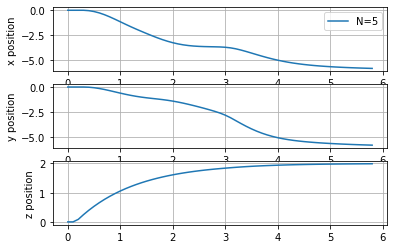

<Figure size 432x288 with 0 Axes>

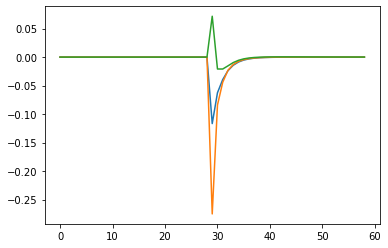

In [30]:
    fig, axs = plt.subplots(3)
    for real_traj in traj:
        real_traj['x'] = np.array(real_traj['x'], dtype=float)
        real_traj['y'] = np.array(real_traj['y'], dtype=float)
        real_traj['z'] = np.array(real_traj['z'], dtype=float)
        time_range = np.arange(0, real_traj['x'].shape[0]*0.1-0.01, 0.1)
        axs[0].plot(time_range, real_traj['x'])
        axs[0].set_ylabel('x position')
        axs[0].grid()

    for real_traj in traj:
        real_traj['x'] = np.array(real_traj['x'], dtype=float)
        real_traj['y'] = np.array(real_traj['y'], dtype=float)
        real_traj['z'] = np.array(real_traj['z'], dtype=float)
        time_range = np.arange(0, real_traj['y'].shape[0]*0.1-0.01, 0.1)
        axs[1].plot(time_range, real_traj['y'])
        axs[1].set_ylabel('y position')
        axs[1].grid()

    plt.figure(2)
    for real_traj in traj:
        real_traj['x'] = np.array(real_traj['x'], dtype=float)
        real_traj['y'] = np.array(real_traj['y'], dtype=float)
        real_traj['z'] = np.array(real_traj['z'], dtype=float)
        time_range = np.arange(0, real_traj['z'].shape[0]*0.1-0.01, 0.1)
        axs[2].plot(time_range, real_traj['z'])
        axs[2].set_ylabel('z position')
        axs[2].grid()
    axs[0].legend(['N=5','N=10','N=15'])
    
    fig.savefig('time_horizon.pdf')
    plt.show()
    



    
    # plt.figure(3)
    #plt.plot(np.square((np.array(real_trajectory['x'])-np.array(est_trajectory['x'])).reshape(-1,1)))#,axis=1))
    
    # plt.plot(np.array(real_trajectory['z']).reshape(-1,1))#,axis=1))
    # plt.plot(np.array(est_trajectory['z']).reshape(-1,1))
    
    plt.plot(np.array(d_hat_list).reshape(-1,3)-real_disturbance)

In [31]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import numpy as np
from matplotlib import animation
from Quadrotor import Quadrotor_linear

from MPC_controller import mpc_control,mpc_control_stable,OTS,get_observer_gain,luenberger_observer
from visualization import data_for_cylinder_along_z
from convexification import get_intermediate_goal, convexify

np.random.seed(seed=0)
drone = [0,0,0.05]  #pos_x,pos_y,radius
obs1=np.array([-3,1,1])   #pos_x,pos_y,radius
obs2=np.array([-2,-3,1])  #pos_x,pos_y,radius
obs3=np.array([0,2,1]) #pos_x,pos_y,radius
obs4=np.array([-5,-1.9,1]) #pos_x,pos_y,radius
obs5=np.array([0.5,-2,1]) #pos_x,pos_y,radius
#obs6=np.array([-4,-4,1])/1.
obstacle_list=[obs1,obs2,obs3,obs4,obs5]#,obs6]#,obs1*2,obs2*2,obs3*2,obs4*2,obs5*2]

goal = np.array([-5,-5,2]) #pos_x,pos_y,pos_z

sensor_noise_sigma=np.array([0.05,0.05,0.05,0.001,0.001,0.001,0.001,0.001,0.001,0.001])

#sensor_noise_sigma = np.zeros(10)
real_disturbance=np.random.normal(loc=0,scale=0.01,size=3)
print("real _dist", real_disturbance)

Cd= np.zeros((10,3))

Bd= np.array([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 0],
              [1, 0, 0],
              [0, 1, 0],
              [0, 0, 1],
              [0, 0, 0],
              [0, 0, 0],
              [0, 0, 0],
              [0, 0, 0]])


obs_eigen_values= np.array([-0.1, -0.1, -0.1, -0.03, -0.03, -0.03, 0.3, 0.3, 0.6, 0.6, -0.05, -0.05, -0.05])
#obs_eigen_values= np.array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -0.7, -0.7,-0.7])
def animate(i):
    line.set_xdata(real_trajectory['x'][:i + 1])
    line.set_ydata(real_trajectory['y'][:i + 1])
    line.set_3d_properties(real_trajectory['z'][:i + 1])
    
    line_est.set_xdata(real_trajectory['x'][:i + 1])
    line_est.set_ydata(real_trajectory['y'][:i + 1])
    line_est.set_3d_properties(real_trajectory['z'][:i + 1])
    point.set_xdata(real_trajectory['x'][i])
    point.set_ydata(real_trajectory['y'][i])
    point.set_3d_properties(real_trajectory['z'][i])

if __name__ == "__main__":
    
    N = 10

    quadrotor_linear = Quadrotor_linear()

    x_init = np.zeros(10)
    x_init[0]=drone[0]
    x_init[1]=drone[1]
    
    x_target = np.zeros(10)
    x_target[0] = goal[0]
    x_target[1] = goal[1]
    x_target[2] = goal[2]
    
    x_hat = x_init
    x_real = x_init
    d_hat=np.zeros((3,1))
    output = x_init
    
    L=get_observer_gain(quadrotor_linear, Bd,Cd,obs_eigen_values)
    A,b = convexify(x_init[:2].flatten(),drone[2],obstacle_list)
    
    inter_goal=get_intermediate_goal(x_init[:2].flatten(), 0, x_target[:2].flatten(), A,b).flatten()
    x_intergoal=np.zeros(10)
    x_intergoal[:2]=inter_goal
    x_intergoal[2] = x_target[2]

    real_trajectory = {'x': [], 'y': [], 'z': []}
    est_trajectory = {'x': [], 'y': [], 'z': []}
    output_trajectory = {'x': [], 'y': [], 'z': []}
    
    d_hat_list=[]
    x_ref,u_ref = OTS(quadrotor_linear,x_intergoal,d_hat, A, b, Bd, Cd)

    i = 0
    while np.linalg.norm(x_intergoal[:3].flatten()-x_target[:3]) > 0.1:
        
        i += 1

        A_obs,b_obs=convexify(x_hat[:2].flatten(),drone[2],obstacle_list)

        output = quadrotor_linear.disturbed_output(x_real,real_disturbance, Cd, sensor_noise_sigma)
        
        u = mpc_control(quadrotor_linear, N, x_hat.flatten(), x_ref.flatten(),u_ref.flatten(),A_obs,b_obs)

        if u is None:
            print("no solution")
            u=np.zeros((4,1))
        else:
            u = u.reshape(-1,1)

        est_trajectory['x'].append(x_hat[0])
        est_trajectory['y'].append(x_hat[1])
        est_trajectory['z'].append(x_hat[2])
        
        real_trajectory['x'].append(x_real[0])
        real_trajectory['y'].append(x_real[1])
        real_trajectory['z'].append(x_real[2])
        
        output_trajectory['x'].append(output[0])
        output_trajectory['y'].append(output[1])
        output_trajectory['z'].append(output[2])
        
        x_real = quadrotor_linear.disturbed_next_x(x_real,u,real_disturbance,Bd)
        
        x_hat, d_hat = luenberger_observer(quadrotor_linear, x_hat, d_hat, output, u, Bd, Cd, L)
        
        d_hat_list.append(d_hat)
        
        A_obs,b_obs = convexify(x_hat[:2].flatten(),drone[2],obstacle_list)

        x_intergoal[:2] = get_intermediate_goal(output[:2].flatten(), 0,x_target[:2].flatten(), A_obs,b_obs).flatten()
        
        x_ref,u_ref = OTS(quadrotor_linear, x_intergoal, d_hat, A_obs, b_obs, Bd, Cd)

        if x_ref is None :
            x_ref = x_intergoal
            u_ref = np.zeros((4,1))
        #print("x_error:",(x_real).flatten())
        print(i)
        print("x_real :",x_real)
        #print("\n")
        #print("ref:",x_ref,u_ref)
        
    A,b = convexify(x_hat[:2].flatten(),drone[2],obstacle_list)
    print("***")

    while np.linalg.norm(x_real[:3].flatten() - x_target[:3]) >= 0.3 and i<=2000:
        i+=1
        
        output = quadrotor_linear.disturbed_output(x_real,real_disturbance, Cd, sensor_noise_sigma)
         
        u = mpc_control_stable(quadrotor_linear, 30, x_hat.flatten(), x_ref.flatten(),u_ref.flatten(),A,b)


        if u is None:
            print("no solution")
            u=np.zeros((4,1))
        else:
            u = u.reshape(-1,1)

        est_trajectory['x'].append(x_hat[0])
        est_trajectory['y'].append(x_hat[1])
        est_trajectory['z'].append(x_hat[2])
        
        real_trajectory['x'].append(x_real[0])
        real_trajectory['y'].append(x_real[1])
        real_trajectory['z'].append(x_real[2])
        
        output_trajectory['x'].append(output[0])
        output_trajectory['y'].append(output[1])
        output_trajectory['z'].append(output[2])
        
        x_real = quadrotor_linear.disturbed_next_x(x_real,u,real_disturbance,Bd)
        
        #output = quadrotor_linear.disturbed_output(x_real,real_disturbance, Cd, sensor_noise_sigma).flatten()
        
        x_hat, d_hat = luenberger_observer(quadrotor_linear, x_hat, d_hat, output, u, Bd, Cd, L)
        d_hat_list.append(d_hat)
        x_ref,u_ref = OTS(quadrotor_linear,x_intergoal,d_hat, A,b,Bd,Cd)

        print(x_hat.flatten())
        
        if x_ref is None :
            x_ref = x_intergoal
            u_ref = np.zeros((4,1))

real _dist [0.01764052 0.00400157 0.00978738]
1
x_real : [[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.01764052]
 [ 0.00400157]
 [ 0.89755625]
 [ 0.        ]
 [ 0.        ]
 [ 1.52860991]
 [-2.86852041]]
2
x_real : [[ 1.76405235e-03]
 [ 4.00157208e-04]
 [ 8.97556247e-02]
 [ 3.52810469e-02]
 [ 8.00314417e-03]
 [ 1.32889221e+00]
 [ 1.52860991e-01]
 [-2.86852041e-01]
 [ 7.31208023e-01]
 [-1.36948864e+00]]
3
x_real : [[ 5.29215704e-03]
 [ 1.20047163e-03]
 [ 2.22644846e-01]
 [-2.28480281e-01]
 [-1.37951916e-01]
 [ 1.23029778e+00]
 [ 2.25981794e-01]
 [-4.23800904e-01]
 [ 1.02158818e-01]
 [-1.32334982e-01]]
4
x_real : [[-0.01755587]
 [-0.01259472]
 [ 0.34567462]
 [-0.62658844]
 [-0.35563848]
 [ 1.14159625]
 [ 0.23619768]
 [-0.4370344 ]
 [-0.29785239]
 [ 0.39793509]]
5
x_real : [[-0.08021472]
 [-0.04815857]
 [ 0.45983425]
 [-1.03767867]
 [-0.58334683]
 [ 1.09870817]
 [ 0.20641244]
 [-0.39724089]
 [-0.39545043]
 [ 0.78202736]]
6
x_real : [[-0.18398258]
 [-0.10649325]
 [ 0.56970507]
 [-1.409

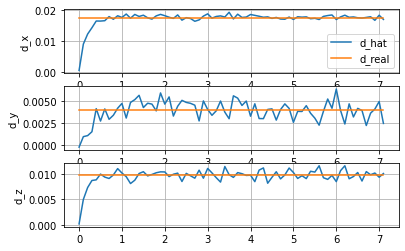

In [32]:
d_hat_list = np.array(d_hat_list).reshape(-1,3)
fig, axs = plt.subplots(3)
time_range = np.arange(0, d_hat_list.shape[0]*0.1-0.01, 0.1)
axs[0].plot(time_range, d_hat_list[:,0], time_range, real_disturbance[0]*np.ones(time_range.shape[0]))
axs[0].grid()
axs[0].set_ylabel('d_x')
axs[1].plot(time_range, d_hat_list[:,1], time_range, real_disturbance[1]*np.ones(time_range.shape[0]))
axs[1].grid()
axs[1].set_ylabel('d_y')
axs[2].plot(time_range, d_hat_list[:,2], time_range, real_disturbance[2]*np.ones(time_range.shape[0]))
axs[2].set_ylabel('d_z')
axs[2].grid()
axs[0].legend(["d_hat","d_real"])
plt.savefig('disturbance.pdf')

plt.show()

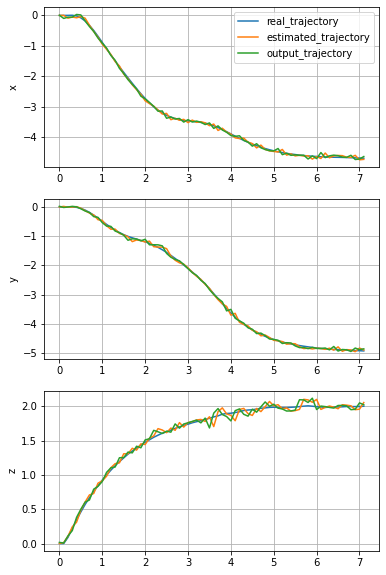

In [33]:
real_trajectory['x'] = np.array(real_trajectory['x'], dtype=float)
real_trajectory['y'] = np.array(real_trajectory['y'], dtype=float)
real_trajectory['z'] = np.array(real_trajectory['z'], dtype=float)

est_trajectory['x'] = np.array(est_trajectory['x'], dtype=float)
est_trajectory['y'] = np.array(est_trajectory['y'], dtype=float)
est_trajectory['z'] = np.array(est_trajectory['z'], dtype=float)

output_trajectory['x'] = np.array(output_trajectory['x'], dtype=float)
output_trajectory['y'] = np.array(output_trajectory['y'], dtype=float)
output_trajectory['z'] = np.array(output_trajectory['z'], dtype=float)

fig, axs = plt.subplots(3, figsize=(6,10))
time_range = np.arange(0, real_trajectory['x'].shape[0]*0.1-0.01, 0.1)

axs[0].plot(time_range, real_trajectory['x'], time_range, est_trajectory['x'], time_range, output_trajectory['x'])
axs[0].grid()
axs[0].set_ylabel('x')
axs[1].plot(time_range, real_trajectory['y'], time_range, est_trajectory['y'], time_range, output_trajectory['y'])
axs[1].grid()
axs[1].set_ylabel('y')
axs[2].plot(time_range, real_trajectory['z'], time_range, est_trajectory['z'], time_range, output_trajectory['z'])
axs[2].grid()
axs[2].set_ylabel('z')
axs[0].legend(["real_trajectory","estimated_trajectory","output_trajectory"])
plt.savefig('observer.pdf')

plt.show()